# 4 weeks

#### Imports and config

In [1]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
from model_functions import *

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', 50)
np.set_printoptions(threshold=1000)#np.inf

#### Load file

In [5]:
with open("./4week_transformed_droppedErrors_filled.pkl", "rb") as pickleFile:
    ds = pickle.load(pickleFile)
ds.index = pd.to_datetime(ds.index)

#### Prediction Column

In [6]:
prediction_column = 'cpuusage_ps' #cpuusage_ps,host_cpu_usage_pct 
ds["cpu"] = pd.to_numeric(ds[prediction_column], errors='coerce')
ds = ds.drop(prediction_column,1)

## Train/Test Split

In [97]:
measureInterval = 15 #min
hoursToPredict = 4
pred_horizon = int((60//measureInterval) * hoursToPredict) #(4*hours), timestep = 15min

In [98]:
data = ds.cpu
y_train = data[:-pred_horizon]
y_test = data[-pred_horizon:]

## Measure Performance

In [69]:
ml_mods = ['ar', 'arima', 'sarima'] # optional : 'arima', 'sarima'
measure_performance_ar(y_train, y_test, ml_mods)

/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,MSE,RMSE,MAE,MAPE,R2
ar,1.945360,1.394762,0.894722,59.567595,0.574525
arima,0.804390,0.896878,0.755105,114.649138,0.824070
sarima,1.038722,1.019177,0.812629,94.047584,0.772818


#### Augmented Dickey-Fuller-Test

In [63]:
data_ad = ds.cpu
result = adfuller(data_ad.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.376731
p-value: 0.000000


## AR

In [99]:
model_ar = AR(y_train)
model_ar_fit = model_ar.fit(maxlag= 20,ic='bic', trend='nc', method='cmle', maxiter=20)

/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


In [100]:
print('Lag: %s' % model_ar_fit.k_ar)

Lag: 20


In [101]:
pred_test = model_ar_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=True)

In [102]:
get_score(y_test,pred_test)

MSE : 1.9453602046924239
RMSE: 1.3947617017585563
MAE : 0.8947222760039346
MAPE: 59.567594810495926
R2  : 0.5745246090355856


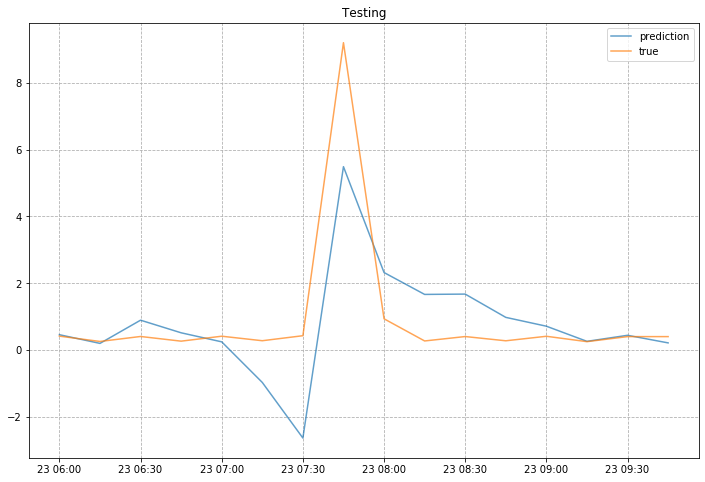

In [103]:
plot_train_test_ar(pred_test, y_test)

## ARIMA

In [16]:
model_arima = ARIMA(y_train,order=(20,0,3))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)


11197.630647259895


In [17]:
print(model_arima_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    cpu   No. Observations:                 2773
Model:                    ARMA(20, 3)   Log Likelihood               -5573.815
Method:                       css-mle   S.D. of innovations              1.799
Date:                Wed, 08 Apr 2020   AIC                          11197.631
Time:                        17:36:28   BIC                          11345.823
Sample:                    12-25-2019   HQIC                         11251.149
                         - 01-23-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1174      0.153      7.325      0.000       0.818       1.416
ar.L1.cpu     -0.1328      0.019     -6.859      0.000      -0.171      -0.095
ar.L2.cpu      0.0502      0.016      3.060      0.0

In [18]:
pred_test_arima = model_arima_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=True)

In [19]:
get_score(y_test,pred_test_arima)

MSE : 0.804390061558334
RMSE: 0.8968779524318423
MAE : 0.7551051947181001
MAPE: 114.64913751052651
R2  : 0.8240695090277466


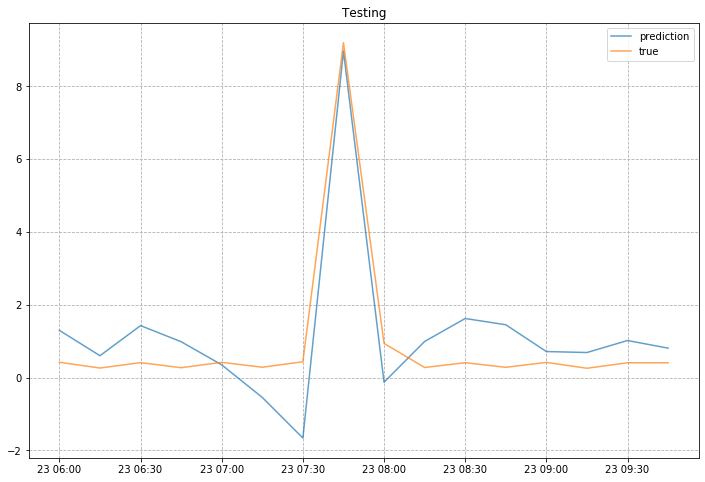

In [20]:
plot_train_test_ar(pred_test_arima, y_test)

## SARIMA

In [45]:
model_sarima = sm.tsa.statespace.SARIMAX(ds.cpu, trend="c",order=(20,0,2))
model_sarima_fit = model_sarima.fit(disp=False)

/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 15T will be used.
  % freq, ValueWarning)
/Users/jan/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [46]:
print(model_sarima_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                    cpu   No. Observations:                 2789
Model:              SARIMAX(20, 0, 2)   Log Likelihood               -5717.401
Date:                Wed, 08 Apr 2020   AIC                          11482.801
Time:                        17:48:31   BIC                          11625.204
Sample:                    12-25-2019   HQIC                         11534.213
                         - 01-23-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5126      0.152      3.380      0.001       0.215       0.810
ar.L1         -0.0679      0.010     -6.953      0.000      -0.087      -0.049
ar.L2          0.2088      0.008     25.977      0.0

In [47]:
pred_test_sarima = model_sarima_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=True)

In [48]:
get_score(y_test,pred_test_sarima)

MSE : 1.0338134978987603
RMSE: 1.0167661962805217
MAE : 0.8167270925190309
MAPE: 102.34264982624191
R2  : 0.7738916416909487


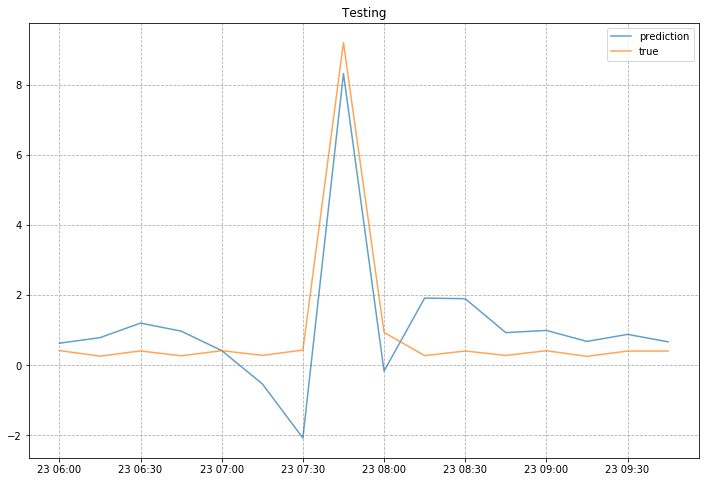

In [49]:
plot_train_test_ar(pred_test_sarima, y_test)

## Summary

Arima performs well on short time forecasting and only when the AR part is set to 20, which is the periodic peak (job), because there is the strongest correlation. 